# Saving image matching results for the SILDa matching task

This assumes that the data are already downloaded. If not, please run in a terminal
```bash
sh download.sh
```

More details on the `readme.md`.

In [1]:
import numpy as np
import cv2
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import h5py
import os

In [2]:
# Load the file with the image pairs that need to be matched for the evaluation
matching_pairs = [line.strip().split() for line in open("data/SILDa/image-matching-task-pairs.txt", 'r')]

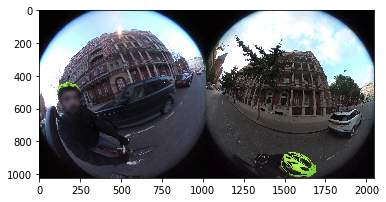

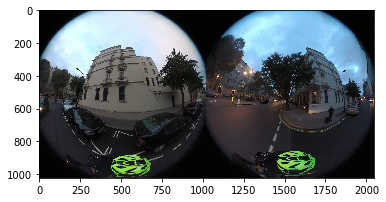

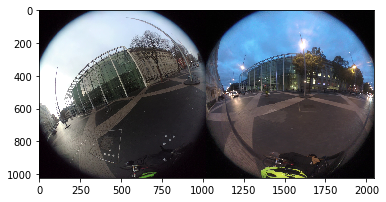

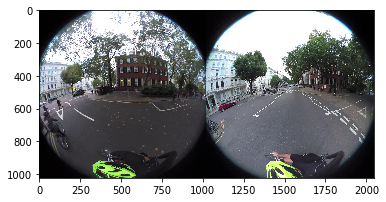

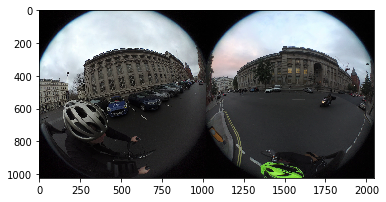

In [3]:
# Visualise a the first 5 evaluation pairs
for pair in matching_pairs[0:5]:
    imgL = cv2.imread(os.path.join("data","SILDa","silda-images",pair[0]))
    imgR = cv2.imread(os.path.join("data","SILDa","silda-images",pair[1]))
    pair_img = np.hstack((imgL,imgR))
    plt.imshow(cv2.cvtColor(pair_img, cv2.COLOR_BGR2RGB))
    plt.show()


# Find matches between all the SILDa evaluation pairs

In the example below, we just use openCV ORB to show how to save the matches in the format required by SILDa, and submit the results.
You can replace the matching process with your own method, and save the results 
in a `.h5` file as shown below.

The results must be saved on a `.h5` file, where one key represents all the matched points 
for an image pair. 
For each image pair, assuming $M$ matches were found, the results must be stored in a numpy
array of size $M\times4$ with $M$ rows, where each row is of the format $x1,y1,x2,y2$, 
where $(x1,y1)$ is the pixel position from the left image of the pair (`pair[0]`), and where $(x2,y2)$ is the pixel position from the right image of the pair (`pair[1]`). The dataset key in the `.h5` file, is given by `str(pair)` as shown in the example below.

In [4]:
# Loop through all images and extract features
img_filenames = glob.glob("data/SILDa/silda-images/*.png")
orb = cv2.ORB_create()
img_feats = {}

for fname in tqdm(img_filenames):
    img = cv2.imread(fname,0)
    kp, desc = orb.detectAndCompute(img,None)
    img_idx = fname.split("/")[-1]
    img_feats[img_idx] = {"kp":kp, "desc":desc, "path":fname}

100%|██████████| 14408/14408 [23:06<00:00,  9.17it/s]


In [5]:
# Fill in submission information - IMPORTANT
METHOD_NAME = "ORB-Matcher"
AUTHOR_NAME = "Jack Matcher"
AUTHOR_EMAIL = "jack@matching.com"

# Init the h5 file with the results
matching_results_file = h5py.File(METHOD_NAME+'-silda-matching-results.h5', 'w')

# Init a BFMatcher with default ORB params
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Loop through all the pairs, and store the matches
for pair in tqdm(matching_pairs):
    # Load the pair details (keypoints, descriptors, paths)
    img_idxL = pair[0]
    img_idxR = pair[1]
    descL = img_feats[img_idxL]['desc']
    descR = img_feats[img_idxR]['desc']
    kpL = img_feats[img_idxL]['kp']
    kpR = img_feats[img_idxR]['kp']
    pathL = img_feats[img_idxL]['path']
    pathR = img_feats[img_idxR]['path']
    # Try to match descriptors
    matches = bf.knnMatch(descL,descR, k=2)
    # Apply ratio test
    good = [] # just for openCV visualisation
    final_matches_silda_format = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
            (x1,y1) = kpL[m.queryIdx].pt
            (x2,y2) = kpR[m.trainIdx].pt
            final_matches_silda_format.append([x1,y1,x2,y2])
    final_matches = np.array(final_matches_silda_format)
    print(final_matches)
    matching_results_file.create_dataset(str(pair), data=final_matches)

    # Visual inspection of matches - warning: this will save images, 
    # and might result in lots of files
    VIS_DEBUG=False
    if (VIS_DEBUG):
        import os
        debug_dir = "debug_matches"
        if not os.path.exists(debug_dir):
            os.makedirs(directory)
        imgL = cv2.imread(pathL)
        imgR = cv2.imread(pathR)
        # visually check the saved final matches in SILDa required format
        for match in final_matches:
            cv2.circle(imgL, (int(match[0]),int(match[1])), 10, 255)
            cv2.circle(imgR, (int(match[2]),int(match[3])), 10, 255)    
        cv2.imwrite(os.path.join(debug_dir,str(pair)+"L_keypoints.png"), imgL)
        cv2.imwrite(os.path.join(debug_dir,str(pair)+"R_keypoints.png"), imgR)
        # visually check the matches in openCV format
        img3 = cv2.drawMatchesKnn(imgL,kpL,imgR,kpR,good,None, flags=2)
        cv2.imwrite(os.path.join(debug_dir,str(pair)+"L_keypoints.png"), imgR)
        break
        
matching_results_file['method_name'] = np.string_(METHOD_NAME) 
matching_results_file['contact_name'] = np.string_(AUTHOR_NAME) 
matching_results_file['contact_email'] = np.string_(AUTHOR_EMAIL) 
matching_results_file.close()             

100%|██████████| 335626/335626 [10:45<00:00, 520.01it/s]


# Submission guidelines
`ORB-Matcher-silda-matching-results.h5` now contains the descriptors for the simple `ORB-Matcher` method which was included as an example. 
Replace the matching process with your method, and do not forget to fill in the required information as shown below:

```python
# Fill in submission information - IMPORTANT
METHOD_NAME = "ORB-Matcher"
AUTHOR_NAME = "Jack Matcher"
AUTHOR_EMAIL = "jack@matching.com"
```

Finally, please upload the resulting `.h5` file [using this link](https://www.dropbox.com/request/03Jp7P1TROvmIIpXju6U?oref=e)

If for any reason the above link does not work, or you cannot access it please send an email to [vassileios@scape.io](mailto:vassileios@scape.io)